In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
def f(x):
    y = 3*(x**2) - 4*x + 5
    return y

In [3]:
f(3.0)

20.0

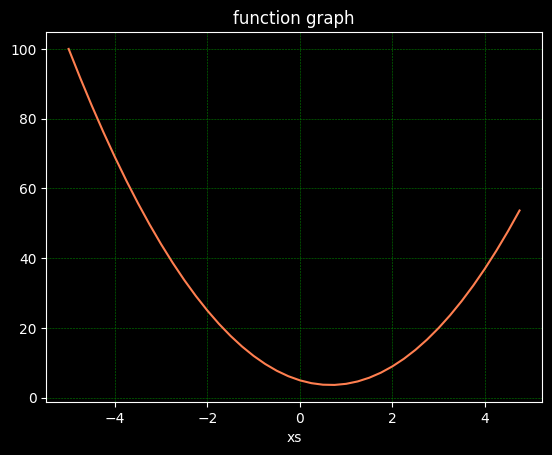

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, c = 'coral')
plt.title("function graph")
plt.xlabel("xs")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.4)

In [5]:
h = 0.0001
x = 3.0
(f(x + h) - f(x))/h

14.000300000063248

In [6]:
class Value:
  
  # note: consider the word "childern" in the reverse graph sense.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._backward = lambda: None
    self.grad = 0.0
    self._op = _op
    self.label = label

  # repr for class pretty print
  def __repr__(self):
    return f"Value(label={self.label} data={self.data})"
  
  def __add__(self, other):
    # if other is a Value assign to itslef, otherwise it must be a constant, so wrap it as a Value first.
    other = other if isinstance(other, Value) else Value(other)

    # do the addition operation.
    out = Value(self.data + other.data, (self, other), '+')

    def _local_derviative_of_each_child():
      # see Note 1 below, that with addition operation, the derivative for each child operand is
      # always 1.  Then due to the chain rule, we multiple by the deriviative of the output.  
      # Note, we need += instead of equal beacus the chain rule is additive if the same node is 
      # differentiated multiple times.
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    # for the reslut of add operation, link to a lambda function that can compute the derivative 
    # for each of the two child operands.
    out._backward = _local_derviative_of_each_child

    return out

  # If someone tries to add a+2, that is covered above, where the 2 will be wrapped as a Value.
  # However, if someone trise, 2+a, then the 2 can;t be conveted into a value, Python checks if __radd__
  # is defined, and self is from a, and other is 2, we can then call add.
  def __radd__(self, other): # other + self
    return self + other

  def __mul__(self, other):
    # if other is a Value assign to itslef, otherwise it must be a constant, so wrap it as a Value first.
    other = other if isinstance(other, Value) else Value(other)

    # do the multiply operation.
    out = Value(self.data * other.data, (self, other), '*')

    def _local_derviative_of_each_child():
      # see Note 1 below, that with multiplication operation, the derivative for one child operand is
      # always value of other child operand in the multiply.  Then due to chain rule, we multiply with 
      # the deriviatve of the output.  Note, we need += instead of
      # equal beacus the chain rule is additive if the same node is differentiated multiple times.
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    # for the reslut of add operation, link to a lambda function that can compute the derivative 
    # for each of the two child operands.
    out._backward = _local_derviative_of_each_child

    return out

  # If someone tries to multiply a*2, that is covered above, where the 2 will be wrapped as a Value.
  # Howeverm if someone trise, 2*a, then the 2 can;t be conveted into a value, Python checks if __rmul__
  # is defined, and self is from a, and other is 2, we can then call mult.
  def __rmul__(self, other):
    return self * other

  def exp(self):
    x = self.data

    # do the e**x operation.
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _local_derviative_of_each_child():
      self.grad += out.data * out.grad 
    out._backward = _local_derviative_of_each_child
    
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _local_derviative_of_each_child():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _local_derviative_of_each_child

    return out

  def __truediv__(self, other): # self / other
    # do the division through multiply of reciprocal operation.
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self):
    x = self.data

    # definition of tanh interems of e**x,  See Note 3
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    # tanh has only one child.  Deriavative is calculated symbolically with calculus. See Note 3.
    def _local_derviative_of_each_child():
      self.grad += (1 - t**2) * out.grad
    out._backward = _local_derviative_of_each_child
    
    return out
  # Call _backward() on each node in reverse topological order.  See Note #2 for detail.  
  def backward(self):

      # topological order all of the children in the graph
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
      build_topo(self)

      # go one variable at a time and apply the chain rule to get its gradient
      self.grad = 1
      for v in reversed(topo):
          v._backward()      

In [7]:
# draw nodes in graph/tree visualation.
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

# Here L is like our "loss" function.  The scalar values above are like our "weights".
L = d * f; L.label = 'L' # ((a*b)+c)*f
L
L._prev

{Value(label=d data=4.0), Value(label=f data=-2.0)}

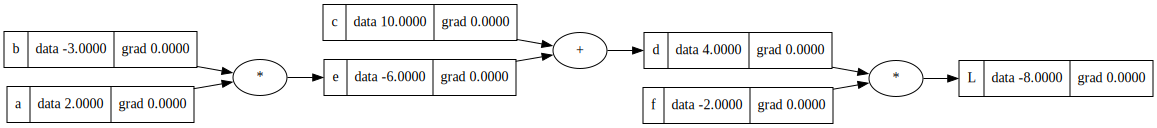

In [9]:
draw_dot(L)

In [10]:
# if L is like the loss function and the values are like the weghts, we will want to do backpropegtion to 
# figure out optimial weights that minimize the L, the loss fuction.  We start by computing the derviative 
# of each wieght with respect to L

# We add a variable named "grad" to Value class to hold the derevative of that value with respect to L.  
# grad is initialized to 0 wich means 0 slope, or that changes in this variable does not induce changes in L.

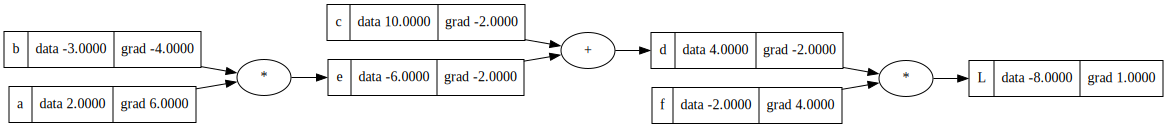

In [11]:
# Note 1

# dL/dL is always 1
#
# dL/dd is d(d*f)/dd since L=d*f.  By calculas, that is just f.  dL/dd = d(d*f)/dd = f.
# dL/df is d(d*f)/df since L=d*f.  By calculas, that is just d.  dL/df = d(d*f)/df = d.
# so with the multiplication operation, the derviative of L by one operand is the value of the other.
#
# We will compute dL/dc and DL/de by the chain rule.  dL/dc = dd/dc * DL/dd.
# dd/dc is d(e+c)/dc since d = e+c.  By calculas, that is just 1. dd/dc = 1.  
# thus DL/dc = 1 * DL/dd = 1 * f = f  
# so with the adddition operations, the derivative of L by one operatand is the deraviate of the reuslt of the addition.
# so then DL/de is also DL/de = 1 * DL/dd = 1 * f = f
# 
# We can keep going up the tree with * and +, using the chain rule to get gradents for all.
L.grad =  1  # this is dL/dL = 1 by definition.
f.grad =  4  # this is dL/df = d which is value  4. 
d.grad = -2  # this is dL/dd = f which is value -2. 
c.grad = -2  # this is dL/dc = 1*f which is vaule -2. 
e.grad =  -2 # this is dL/de = 1*f which is vaule -2. 
b.grad =  -4 #  2*(-2) this is dL/db which is the value of a * dL/de = 2*(-2) which is value of -4 
a.grad =   6 # -3*(-2) this is dL/da which is the value of b * dL/de = -3*(-2) which is value of 6 
draw_dot(L)

In [12]:
# now that we have the gradients, we do do a gradient decent.  For each leaf node (a, b, c, and f), we can move a tiny step in 
# the direction of the gradient.  Moving in the direction of the gradient should increase L.  Lets try.
step = 0.01
a.data += step*a.grad
b.data += step*b.grad
c.data += step*c.grad
f.data += step*f.grad

# recompute the forward pass
e = a * b
d = e + c
L = d * f
print(L.data) # it works, -7.286 is bigger than -8!!!

-7.286496


In [13]:
# so clealry, for each operation we have, we need to have the derivate computation as well.
# so to our value function, lets compute the deriviative for each operation.



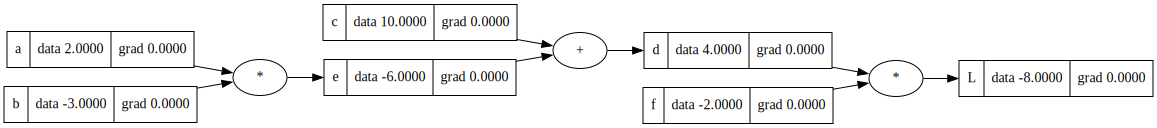

In [14]:
# Now that we have added the ability to comptue derviative of each child operand from the output of each operation,
# lets do the back propegation in a more automated way.

# start out by resetting the computational graph:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # ((a*b)+c)*f

draw_dot(L)

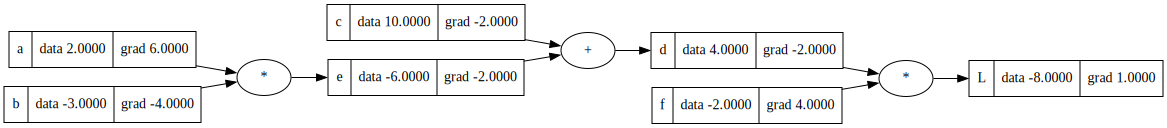

In [15]:
L.grad = 1.0  # start at one, dL/dL is awlays 1
L._backward() # from L, compute the gradients for the children operands (f and d)
d._backward() # from d, compute the gradients for the children operands (c and e)
e._backward() # from e, compute the gradients for the children operands (a and b)

draw_dot(L)

In [16]:
# To automatically traverse from L to d, to e, we need a topological sort.  Here is an example:
Image(url="topo.png", width=600)

In [17]:
# Here is the agorithm for topological order all of the children in a tree like ours
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)

In [18]:
# you can see we visit in the order of f, d, and e as desired.  We also have the leaf nodes c, a, b, and f in there
# but they don;t matter, because when we call _backward() on them, it is a Null function.
for node in reversed(topo): 
    print(node)

Value(label=L data=-8.0)
Value(label=d data=4.0)
Value(label=e data=-6.0)
Value(label=a data=2.0)
Value(label=b data=-3.0)
Value(label=c data=10.0)
Value(label=f data=-2.0)


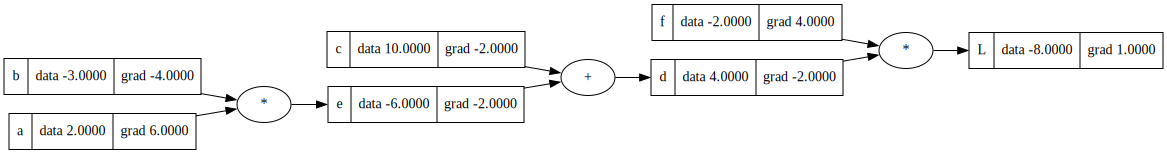

In [19]:
# Note 2

# So now we know how to autmatically traverse in the right order, and call _backward, lets add a funtinon
# in our Value class called backward() do to this all for us.

# start out by resetting the computational graph:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # ((a*b)+c)*f

# Now call our new function.
L.backward()

draw_dot(L) # viola!! we got all the gradients backpropegted correctly!!!

In [20]:
# Now lets build a simple 1 cell neuron.  We have 3 element input vector, X.  
# We have 3 corresponding weights.  We do the dot product.  Add a single bias value.  
# Then pass the result thorugh an activation function that usually squashes the ouptputs in the extremes. 
Image(url="neuron_model.jpeg", width=400)

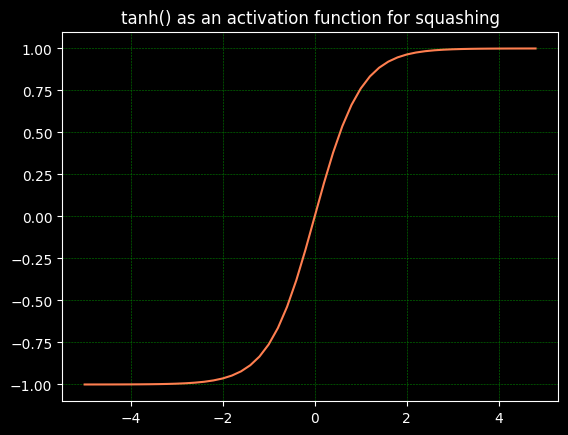

In [21]:
# One choice for activation function that usually squashes the ouptputs in the extremes is tanh. 
x = np.arange(-5,5,0.2)
plt.plot(x, np.tanh(x),c = 'coral')
plt.title("tanh() as an activation function for squashing")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.4)


In [22]:
#Note 3

# tanh is defined mathemetically as: tanh(x) = ((e**2x) - 1) / ((e**2x) + 1).  The derviative of tanh is also:
# d tanh(x) / dx = 1 - (tanh(x))**2

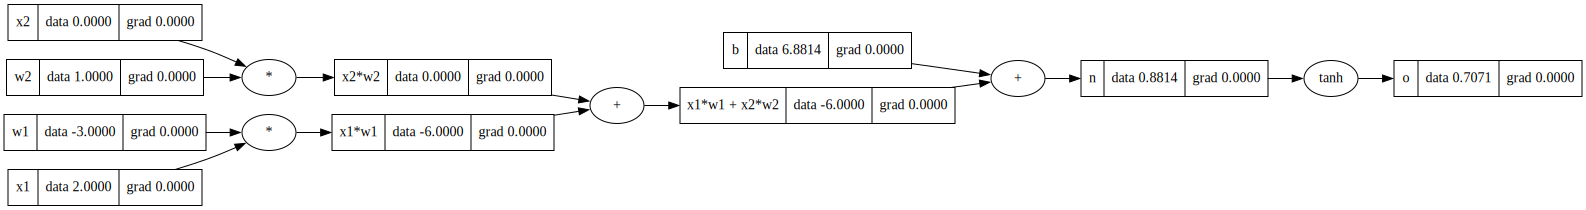

In [23]:
# Our neuron is thus:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b') # we set the bias this way to make the gradient numbers look good

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'

# x2*w2
x2w2 = x2*w2; x2w2.label = 'x2*w2'

# add both products together to get dot product x1w1x2w2 = x1w1 + x2*w2 = x1*w1 + x2*w2
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# now add bias to the dot product (x1w1x2w2 + b) and name that n: 
n = x1w1x2w2 + b; n.label = 'n'

# finally apply the activation function, tanh, and name the result o:
o = n.tanh(); o.label = 'o'

draw_dot(o)

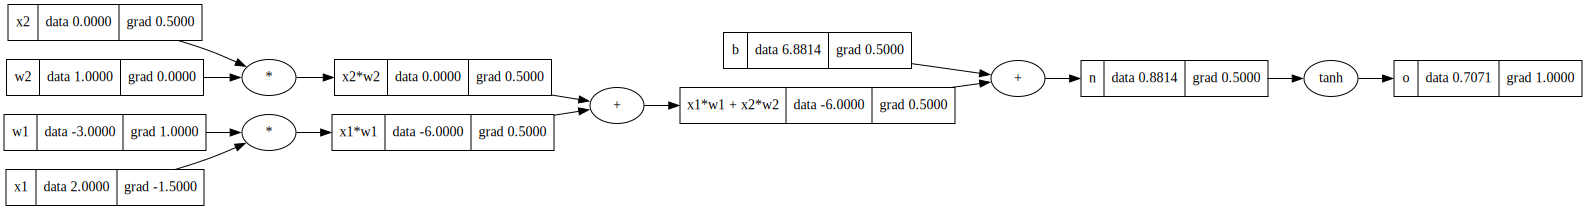

In [24]:
# now backpropegate
o.backward()

draw_dot(o)